In [74]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from statistics import mean
import matplotlib.font_manager
from enum import Enum
from abc import ABC
import abc
from datetime import datetime
import math
import random
from collections import defaultdict, OrderedDict
import uuid
import json

fontName = 'YS Text'
fontColor = '#FF6427'
fontColor2 = '#000000'

font_files = matplotlib.font_manager.findSystemFonts(fontpaths='/usr/share/fonts/truetype')
for font_file in font_files:
    try: 
        matplotlib.font_manager.fontManager.addfont(font_file)
    except Exception:
        print('failed to add font ' + font_file)
        #ignore
font = {'family' : 'YS Text',
        'size'   : 16}

matplotlib.rc('font', **font)

failed to add font /usr/share/fonts/truetype/noto/NotoColorEmoji.ttf


In [15]:
#to speed up testing
MAX_NUM_ROWS=50000
# MAX_NUM_ROWS=10000000000

MEDIASERVER_IDLE_TIMEOUT = 60

#model parameters
ISLAND_SIZES = [50] * 5
RECONNECT_DOWNTIME_SECONDS = 10

#parameters to optimize
GRACE_PERIOD_SECONDS = 1800

#disruptions are done one island at a time. When one rolls out, other islands stay 100% available
DISRUPTION_BUDGET = 50

In [88]:
calls  = pd.read_csv('calls_data_week.tsv', header=0, names=['msid','peer_id', 'room_id', 'rsid', 'ts_connected', 'ts_joined', 'ts_leave', 'ts_offer'], delimiter='\t', nrows=MAX_NUM_ROWS)
print(f"Room Media Sessions loaded: {calls.shape[0]}")
# calls.head(15)

Room Media Sessions loaded: 50000


,msid,peer_id,room_id,rsid,ts_connected,ts_joined,ts_leave,ts_offer
0,0000007e-22c5-44e3-a5b4-6e724cab72f3,ff3983ed0d21ef95c84726261c13062c,476174964b7c4c87a4f1d70de2d768c1,f0f52923-8247-4e7c-a58e-e377c17b5df7,"2023-10-04 12:53:13,550","2023-10-04 12:53:10,991","2023-10-04 13:01:04,423","2023-10-04 12:53:12,446"
1,00001d39-3b30-4556-9c4a-1f3eded0e43c,843e13d0a9d4719f4e6c2f51d2afdde4,bbf146c4e05f4973840efac8086d39a2,b1e97bda-a33f-4b67-b209-2476093badf8,"2023-10-06 13:42:05,821","2023-10-06 13:42:03,634","2023-10-06 13:46:18,365","2023-10-06 13:42:04,982"
2,00003b2d-2518-4325-97e0-aab6467f00f4,5b01803546254b632d9df477d8392b6a,0b3f502c7a8e407aa37165c4e7e88973,efe80b25-1027-46d0-a5ad-e98fb30ecff0,"2023-10-06 10:32:28,067","2023-10-06 10:32:26,391","2023-10-06 10:32:49,821","2023-10-06 10:32:27,224"
3,00004e6f-fee4-471a-bbff-399351a12471,2c47e32aaf4efd1cf14271793c7ad12a,48bb4b75c1e9498986b12886692cd598,a3969583-2b64-4137-bb5d-2d315229f784,"2023-10-06 15:02:05,612","2023-10-06 15:02:04,488","2023-10-06 15:38:53,565","2023-10-06 15:02:05,122"
4,00005d4e-de60-41a0-bd94-deb0f6284f1b,75ba7bf99e68b847ade90cb3aabc3ed7,8dbea6698ce24776abd64e564578b549,ad3700b0-7783-4c46-84ec-d1c414676b99,"2023-10-02 10:30:36,448","2023-10-02 10:30:35,473","2023-10-02 10:39:11,117","2023-10-02 10:30:36,056"
5,00006053-8e1f-42c8-8cf4-6d9a72f67da9,de6640972520cabc51406d9e3fb81be9,ae3b4a8ffada450cb3f48f9b6adf5453,2aff682e-21a2-4069-8222-17c5b5572bae,"2023-10-05 08:58:13,460","2023-10-05 08:58:12,361","2023-10-05 09:22:24,344","2023-10-05 08:58:13,035"
6,00007318-89a1-45c7-aca1-1cec9421242a,e0d1523ddd805ad7ec4b195ef47cda59,2780b442f7b04af7b205c39bf36eebb1,29b7637f-9d55-4857-b9b1-cbec6e31d610,"2023-10-05 14:41:43,238","2023-10-05 14:41:42,213","2023-10-05 19:35:57,912","2023-10-05 14:41:42,750"
7,00008117-5363-4280-8a44-61b0787db874,1ca55eea38a06df36cd07b8a69ecd1dc,c6cc94beb83f44c2916daebebb729f90,53b962c8-4d5e-4db5-9198-1839f648e587,"2023-10-04 13:08:06,460","2023-10-04 13:08:01,095","2023-10-04 16:00:23,416","2023-10-04 13:08:03,718"
8,000086c1-63eb-4a96-b43d-92c5ab3aae13,344f5b361629fefd67708680e656f040,3370f30750c0412687f6e5bbca1578c2,70b7ae66-76ba-46a9-960c-d2f5885dc1c7,"2023-10-06 15:27:15,012","2023-10-06 15:27:01,524","2023-10-06 15:27:13,880","2023-10-06 15:27:02,997"
9,0000916d-bd12-489a-88f2-3364d1217bf2,c5b6247a50b3b48d7451ca4ae18ade3b,9c91308553be4342a7f39682770fed5b,816e132b-78d3-4a52-b65e-7bd6cf218a2e,"2023-10-08 10:59:55,894","2023-10-08 10:59:53,089","2023-10-08 11:00:08,544","2023-10-08 10:59:54,220"


In [132]:
def parseIsoDate(dateStr: str):
    return datetime.strptime(dateStr, '%Y-%m-%d %H:%M:%S,%f')

class RMSConnectionCreationException(Exception):
    reason: str

    def __init__(self, reason: str):
        self.reason = reason

class RMSConnection(ABC):
    room_id: str
    peer_id: str
    msid: str
    rsid: str
    ts_joined: datetime
    ts_connected: datetime
    ts_leave: datetime

    def __str__(self):
        return json.dumps(self, indent=4)

    
    def __init__(self, room_id, peer_id, msid, rsid, ts_joined_str: str, ts_connected_str: str, ts_leave_str: str):
        self.room_id = room_id
        self.peer_id = peer_id
        self.msid = msid
        self.rsid = rsid
        
        if(type(ts_connected_str) == float):
            raise RMSConnectionCreationException('connected')
        else:
            self.ts_connected = parseIsoDate(ts_connected_str)
    
        if(type(ts_joined_str) == float):
            raise RMSConnectionCreationException('joined')
        else:
            self.ts_joined = parseIsoDate(ts_joined_str)
    
        if(type(ts_leave_str) == float):
            raise RMSConnectionCreationException('leave')
        else:
            self.ts_leave = parseIsoDate(ts_leave_str)
    

class PeerConnection(ABC):
    room_id: str
    peer_id: str
    ts_joined: datetime
    ts_connected: datetime
    ts_leave: datetime
    rmsConnections: list[RMSConnection]

    def __init__(self, rmsConnections: list[RMSConnection]):
        self.room_id = rmsConnections[0].room_id
        self.peer_id = rmsConnections[0].peer_id
        self.ts_joined = min(map(lambda conn: conn.ts_joined, rmsConnections))
        self.ts_connected = min(map(lambda conn: conn.ts_connected, rmsConnections))
        self.ts_leave = max(map(lambda conn: conn.ts_leave, rmsConnections))
        self.rmsConnections = rmsConnections
    
    def __str__(self):
        connectionsStr = ''
        for rmsc in self.rmsConnections:
            connectionsStr += f"{rmsc.ts_joined} - {rmsc.ts_leave},"
            
        return f"room_id: {self.room_id}; peer_id: {self.peer_id}; ts_joined: {self.ts_joined}; ts_connected: {self.ts_connected}; ts_leave: {self.ts_leave}; rmsConnections: {connectionsStr}"


#a set of peer connections that were meeting at the same time
class RoomMeeting(ABC):
    room_id: str
    ts_start: datetime
    ts_finish: datetime
    peerConnections: list[PeerConnection]
    id: str

    def __init__(self, rmsConnections: list[RMSConnection]):
        self.room_id = rmsConnections[0].room_id
        self.ts_start = min(map(lambda conn: conn.ts_joined, rmsConnections))
        self.ts_finish = max(map(lambda conn: conn.ts_leave, rmsConnections))
        self.id = str(uuid.uuid4())

        rmsByPeer = defaultdict(list)
        for conn in rmsConnections: rmsByPeer[conn.peer_id].append(conn)

        self.peerConnections = []
        for peer_id, conns in rmsByPeer.items():
            connsBuckets = splitRMSCByOverlaps(conns)
            for bucket in connsBuckets:
                self.peerConnections.append(PeerConnection(bucket))
    def __str__(self):
        return json.dumps(self, indent=4)


class RoomMeetingAssignment(ABC):
    nodeToRoomMeeting: dict[int, dict[datetime, list[RoomMeeting]]] = defaultdict(lambda :defaultdict(list))
    roomMeetingToNode: dict[str, dict[datetime, int]] = defaultdict(lambda: defaultdict(int))

    roomMeetingDict: dict[str, RoomMeeting] = {}

    def __str__(self):
        return json.dumps(self, indent=4)

    def roomMeetingById(self, id: str):
        return roomMeetingDict[id]

    def getCurrentNode(self, rm: RoomMeeting, ts: datetime) -> int:
        nodeAssignmentDates = self.roomMeetingToNode[rm.id].keys()
        
        prevAssignmentDates = filter(lambda date: date < ts, nodeAssignmentDates)

        if any(prevAssignmentDates):
            return self.roomMeetingToNode[rm.id][max(prevAssignmentDates)]
        return None
        

    def assignRoomMeeting(self, rm: RoomMeeting, node: int, ts: datetime):
        curNode: int = self.getCurrentNode(rm, ts)
        if curNode == node:
            return
        
        self.releaseRoomMeeting(rm, ts)

        self.roomMeetingDict[rm.id] = rm
        rmDates = self.nodeToRoomMeeting[node].keys()
        if len(rmDates) > 0:
            lastTs = max(rmDates)
            newNodeRoomMeetingsBeforeAssignment = self.nodeToRoomMeeting[node][lastTs]
            newNodeRoomMeetingsAfterAssignment = newNodeRoomMeetingsBeforeAssignment.copy()
            newNodeRoomMeetingsAfterAssignment.append(rm)
            self.nodeToRoomMeeting[node][ts] = newNodeRoomMeetingsAfterAssignment
        else:
            self.nodeToRoomMeeting[node][ts].append(rm)

    def releaseRoomMeeting(self, rm: RoomMeeting, ts: datetime):
        nodeAssignmentDates = self.roomMeetingToNode[rm.id].keys()
        if len(nodeAssignmentDates) > 0:
            lastNodeAssignmentTs = max(nodeAssignmentDates)
            prevNodeIdx = roomMeetingToNode[rm.id][lastNodeAssignmentTs]

            prevNodeStateTimestamps = self.nodeToRoomMeeting[prevNodeIdx].keys()
            if len(prevNodeStateTimestamps) > 0:
                prevNodeLastStateTs = max(prevNodeStateTimestamps)
                prevNodeLastStateRMs = self.nodeToRoomMeeting[prevNodeIdx][prevNodeLastStateTs]

                prevNodeNewStateRMs = prevNodeLastStateRMs.copy()
                prevNodeNewStateRMs.pop(rm.id)

                #if room meeting has been removed from the room, add record about it
                if prevNodeLastStateRMs != prevNodeNewStateRMs:
                    self.nodeToRoomMeeting[prevNodeIdx][ts] = prevNodeNewStateRMs

class NewNodePolicy(ABC):
    @abc.abstractmethod
    def pickNodeForRoom(ts: datetime) -> int:
        raise 'not implemented'

class RandomNewNodePolicy(NewNodePolicy):
    def  pickNodeForRoom(ts: datetime) -> int:
        return random.randrange(0, sum(ISLAND_SIZES))

lastSelectedRoundRobinNode = sum(ISLAND_SIZES)
class RoundRobinNewNodePolicy(NewNodePolicy):
    def  pickNodeForRoom(ts: datetime) -> int:
        return random.randrange(0, sum(ISLAND_SIZES))
    
    #pick a new media server at random
    RANDOM = 0
    #pick servers sequentially when new conference is needed
    ROUND_ROBIN = 1
    #check out number of sessions on the nodes and pick the least loaded
    LEAST_LOADED = 2
    #pick an island at random and pick the least loaded node on it
    RANDOM_ISLAND_LEAST_LOADED = 3


In [126]:
#methods to work with RMS domain

def splitRMSCByOverlaps(rmsc: list[RMSConnection]) -> list[list[RMSConnection]]:
    conns = sorted(rmsc, key= lambda conn: conn.ts_joined)
    cur_start = conns[0].ts_joined
    cur_end = conns[0].ts_leave
    cur_meeting_bucket = []
    result_meeting_buckets = []
    for conn in conns:
        # print(f"processing room {room_id}: {conn.ts_joined} - {co>=nn.ts_leave}")
        #negative values are OK here
        same_session: bool = (conn.ts_joined - cur_end).total_seconds() < MEDIASERVER_IDLE_TIMEOUT and (cur_start - conn.ts_leave).total_seconds() < MEDIASERVER_IDLE_TIMEOUT
        if (same_session):
            cur_start = min(cur_start, conn.ts_joined)
            cur_end = max(cur_end, conn.ts_leave)
            cur_meeting_bucket.append(conn)
        else:
            if len(cur_meeting_bucket) > 0:
                # print(f"splitting room meeting in room {room_id}: {cur_start} - {cur_end} from {conn.ts_joined} - {conn.ts_leave}")
                result_meeting_buckets.append(cur_meeting_bucket)
            cur_start = conn.ts_joined
            cur_end = conn.ts_leave
            cur_meeting_bucket = [conn]
    if len(cur_meeting_bucket) > 0:
        result_meeting_buckets.append(cur_meeting_bucket)
    
    return result_meeting_buckets

def splitRoomMeetings(sameRoomRMSConnectionsLocal) -> list[RoomMeeting]:
    resultRoomMeetings = []

    for room_id, rmscInOneRoom in sameRoomRMSConnectionsLocal.items():
        resultBuckets = splitRMSCByOverlaps(rmscInOneRoom)
        for bucket in resultBuckets:
            resultRoomMeetings.append(RoomMeeting(bucket))
    
    return resultRoomMeetings

In [133]:
#RMSConnection tests
conn = RMSConnection(
    'room_id',
    'peer_id',
    'msid',
    'rsid',
    '2023-10-04 12:53:13,550',
    '2023-10-04 12:54:13,550',
    '2023-10-04 12:55:13,550'
)
assert conn.room_id == 'room_id'
assert conn.peer_id == 'peer_id'
assert conn.msid == 'msid'
assert conn.rsid == 'rsid'

try:
    conn = RMSConnection('fdsa', 'fdsa', 'fdsa', 'fdsa', float('nan'), '2023-10-04 12:54:13,550', '2023-10-04 12:55:13,550')
except RMSConnectionCreationException as e:
    assert e.reason == 'joined'

try:
    conn = RMSConnection('fdsa', 'fdsa', 'fdsa', 'fdsa', '2023-10-04 12:54:13,550', float('nan'), '2023-10-04 12:55:13,550')
except RMSConnectionCreationException as e:
    assert e.reason == 'connected'

try:
    conn = RMSConnection('fdsa', 'fdsa', 'fdsa', 'fdsa', '2023-10-04 12:54:13,550', '2023-10-04 12:55:13,550', float('nan'))
except RMSConnectionCreationException as e:
    assert e.reason == 'leave'


#RoomMeeting tests
conn11 = RMSConnection('room_id', 'peer_id1', 'msid', 'rsid', '2023-10-04 12:54:13,550', '2023-10-04 12:55:13,550', '2023-10-04 12:56:13,550')
conn12 = RMSConnection('room_id', 'peer_id1', 'msid', 'rsid', '2023-10-04 12:56:30,000', '2023-10-04 12:56:35,000', '2023-10-04 12:57:00,000')
conn13 = RMSConnection('room_id', 'peer_id1', 'msid', 'rsid', '2023-10-04 12:54:13,550', '2023-10-04 12:55:13,550', '2023-10-04 12:56:13,550')

conn21 = RMSConnection('room_id', 'peer_id2', 'msid', 'rsid', '2023-10-04 12:54:13,550', '2023-10-04 12:55:13,550', '2023-10-04 12:56:13,550')
conn22 = RMSConnection('room_id', 'peer_id2', 'msid', 'rsid', '2023-10-04 12:54:13,550', '2023-10-04 12:55:13,550', '2023-10-04 12:56:13,550')
conn23 = RMSConnection('room_id', 'peer_id2', 'msid', 'rsid', '2023-10-04 12:54:13,550', '2023-10-04 12:55:13,550', '2023-10-04 12:56:13,550')

meetings = splitRoomMeetings({ 'room_id': [
    RMSConnection('room_id', 'peer_id1', 'msid', 'rsid', '2023-10-04 12:54:13,550', '2023-10-04 12:55:13,550', '2023-10-04 12:56:00,000'),
    RMSConnection('room_id', 'peer_id1', 'msid', 'rsid', '2023-10-04 12:56:59,000', '2023-10-04 12:57:01,000', '2023-10-04 12:58:00,000'),
    #first meeting ends
    RMSConnection('room_id', 'peer_id1', 'msid', 'rsid', '2023-10-04 12:59:00,000', '2023-10-04 12:59:05,000', '2023-10-04 12:59:30,000'),

    RMSConnection('room_id', 'peer_id2', 'msid', 'rsid', '2023-10-04 12:59:30,000', '2023-10-04 12:59:31,000', '2023-10-04 13:00:00,000'),
    #second meeting ends
    RMSConnection('room_id', 'peer_id2', 'msid', 'rsid', '2023-10-04 13:02:59,000', '2023-10-04 13:03:05,000', '2023-10-04 13:05:00,000'),
    RMSConnection('room_id', 'peer_id2', 'msid', 'rsid', '2023-10-04 13:01:00,000', '2023-10-04 13:01:05,000', '2023-10-04 13:02:00,000'),
    RMSConnection('room_id', 'peer_id2', 'msid', 'rsid', '2023-10-04 13:02:30,000', '2023-10-04 13:02:35,000', '2023-10-04 13:02:50,000'),
]})

assert len(meetings) == 3
assert meetings[0].ts_start == parseIsoDate('2023-10-04 12:54:13,550')
assert meetings[0].ts_finish == parseIsoDate('2023-10-04 12:58:00,000')

assert meetings[1].ts_start == parseIsoDate('2023-10-04 12:59:00,000')
assert meetings[1].ts_finish == parseIsoDate('2023-10-04 13:00:00,000')

assert meetings[1].peerConnections[0].ts_joined ==  parseIsoDate('2023-10-04 12:59:00,000')
assert meetings[1].peerConnections[0].ts_leave ==  parseIsoDate('2023-10-04 12:59:30,000')
assert meetings[1].peerConnections[1].ts_joined ==  parseIsoDate('2023-10-04 12:59:30,000')
assert meetings[1].peerConnections[1].ts_leave ==  parseIsoDate('2023-10-04 13:00:00,000')

assert meetings[2].ts_start == parseIsoDate('2023-10-04 13:01:00,000')
assert meetings[2].ts_finish == parseIsoDate('2023-10-04 13:05:00,000')

#RoomMeetingAssgnment tests

db = RoomMeetingAssignment()
db.assignRoomMeeting(RoomMeeting([RMSConnection('room_id', 'peer_id2', 'msid', 'rsid', '2023-10-04 12:54:13,550', '2023-10-04 12:55:13,550', '2023-10-04 12:56:13,550')]),
                     0,
                     parseIsoDate('2023-10-04 12:54:13,550')
                     )
db.assignRoomMeeting(RoomMeeting([RMSConnection('room_id', 'peer_id2', 'msid', 'rsid', '2023-10-05 12:54:13,550', '2023-10-05 12:55:13,550', '2023-10-05 12:56:13,550')]),
                     0,
                     parseIsoDate('2023-10-04 12:54:13,550')
                     )
db.assignRoomMeeting(RoomMeeting([RMSConnection('room_id', 'peer_id2', 'msid', 'rsid', '2023-10-06 12:54:13,550', '2023-10-06 12:55:13,550', '2023-10-06 12:56:13,550')]),
                     1,
                     parseIsoDate('2023-10-04 12:54:13,550')
                     )
db.assignRoomMeeting(RoomMeeting([RMSConnection('room_id', 'peer_id2', 'msid', 'rsid', '2023-10-07 12:54:13,550', '2023-10-07 12:55:13,550', '2023-10-07 12:56:13,550')]),
                     1,
                     parseIsoDate('2023-10-04 12:54:13,550')
                     )

In [112]:
rmsConnections = [None] * calls.shape[0]
peerConnections: dict[str, PeerConnection] = dict()
#to be split by concurrent groups later. needed to assign media servers to these sessions
sameRoomRMSConnections: dict[str, list[RMSConnection]] = dict()
errorsConnected = []
errorsJoined = []
errorsLeave = []

def registerRMSConnection(rmsc: RMSConnection):
    pcKey = f"{rmsc.room_id}_{rmsc.peer_id}"
    pc: PeerConnection = None
    if(pcKey not in peerConnections):
        pc = PeerConnection([rmsc])
        peerConnections[pcKey] = pc
    else:
        pc = peerConnections[pcKey]
    pc.ts_joined = min(pc.ts_joined, rmsc.ts_joined)
    pc.ts_connected = min(pc.ts_connected, rmsc.ts_connected)
    pc.ts_leave = max(pc.ts_leave, rmsc.ts_leave)
    pc.rmsConnections.append(rmsc)

    sameRoom = None
    if(rmsc.room_id not in sameRoomRMSConnections):
        sameRoom = []
        sameRoomRMSConnections[rmsc.room_id] = sameRoom
    else:
        sameRoom = sameRoomRMSConnections[rmsc.room_id]
    sameRoom.append(rmsc)

In [7]:
for index in range(0, calls.shape[0]):
    try:
        rmsc = RMSConnection(
            calls['room_id'][index],
            calls['peer_id'][index],
            calls['msid'][index],
            calls['rsid'][index],
            calls['ts_joined'][index],
            calls['ts_connected'][index],
            calls['ts_leave'][index]
        )
    except RMSConnectionCreationException as e:
        match e.reason:
            case "joined":
                errorsJoined.append(index)
            case "connected":
                errorsConnected.append(index)
            case "leave":
                errorsLeave.append(index)
            case _:
                raise f"unknown reason {e.reason}"
        
    # rmsc.room_id = calls['room_id'][index]
    # rmsc.peer_id = calls['peer_id'][index]
    # rmsc.msid = calls['msid'][index]
    # rmsc.rsid = calls['rsid'][index]
    
    # if(type(calls['ts_connected'][index]) == float):
    #     errorsConnected.append(index)
    #     continue
    # else:
    #     rmsc.ts_connected = datetime.strptime(calls['ts_connected'][index], '%Y-%m-%d %H:%M:%S,%f')

    # if(type(calls['ts_joined'][index]) == float):
    #     errorsJoined.append(index)
    #     continue
    # else:
    #     rmsc.ts_joined = datetime.strptime(calls['ts_joined'][index], '%Y-%m-%d %H:%M:%S,%f')

    # if(type(calls['ts_leave'][index]) == float):
    #     errorsLeave.append(index)
    #     continue
    # else:
    #     rmsc.ts_leave = datetime.strptime(calls['ts_leave'][index], '%Y-%m-%d %H:%M:%S,%f')
    
    rmsConnections[index] = rmsc
    registerRMSConnection(rmsc)

roomMeetings = splitRoomMeetings(sameRoomRMSConnections)

print(f"connected errors: {len(errorsConnected)}\nJoined errors: {len(errorsJoined)}\nLeave errors: {len(errorsLeave)}\nPeer connections: {len(peerConnections)}\nRoom IDs: {len(sameRoomRMSConnections)}\nRoom Meetings: {len(roomMeetings)}")
# print({k: str(peerConnections[k])  for k in list(peerConnections)[:10]})



connected errors: 3161
Joined errors: 0
Leave errors: 74
Peer connections: 45695
Room IDs: 37876
Room Meetings: 42331


In [8]:
def countRoomMeetingsAt(ts: datetime):
    result = 0
    for rm in roomMeetings:
        if(rm.ts_start <= ts and rm.ts_finish >= ts): result+=1
    return result


def countPeerConnectionsAt(ts: datetime):
    result = 0
    for rm in roomMeetings:
        if(rm.ts_start > ts or rm.ts_finish < ts): continue
        for pc in rm.peerConnections:
            if (pc.ts_joined <= ts and pc.ts_leave >= ts): result += 1
    return result
            
#countRoomMeetingsAt(datetime.strptime('2023-10-04 10:35:36,448', '%Y-%m-%d %H:%M:%S,%f'))
#countPeerConnectionsAt(datetime.strptime('2023-10-04 10:35:36,448', '%Y-%m-%d %H:%M:%S,%f'))


In [9]:

start_date=datetime.strptime('2023-10-04 10:30:00,000', '%Y-%m-%d %H:%M:%S,%f')
end_date=datetime.strptime('2023-10-04 11:30:00,000', '%Y-%m-%d %H:%M:%S,%f')

date_range = list(pd.date_range(start_date, end_date, freq='30S'))
roomMeetingsValues = list(map(lambda date: countRoomMeetingsAt(date), date_range))
concurrentPeerConnectionsValues = list(map(lambda date: countPeerConnectionsAt(date), date_range))

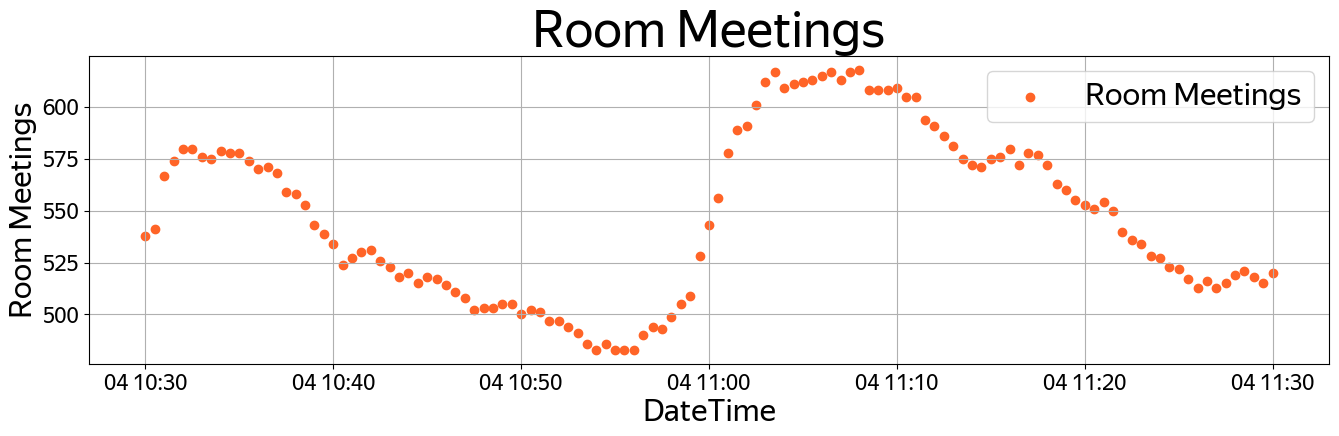

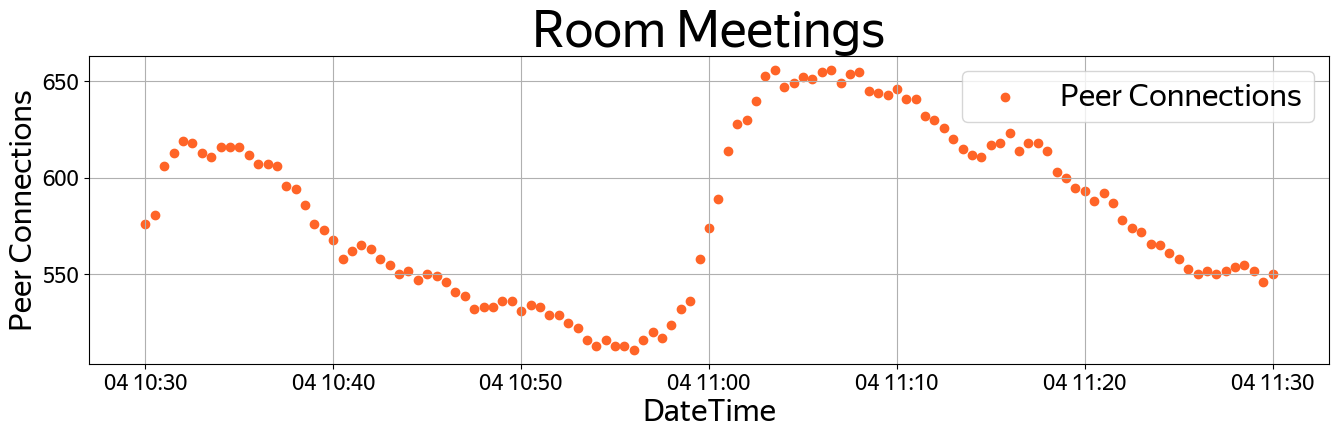

In [10]:
fig = plt.figure(figsize=(16, 4))
ax = fig.add_subplot(111)
ax.set_title('Room Meetings', fontsize=36, fontname=fontName)
ax.set_xlabel('DateTime', fontsize=22, fontname=fontName)
ax.set_ylabel('Room Meetings', fontsize=22, fontname=fontName)
plt.scatter(x=date_range, y=roomMeetingsValues, color=fontColor, label='Room Meetings')
ax.grid()
plt.legend(fontsize=22, loc ="upper right")

fig = plt.figure(figsize=(16, 4))
ax = fig.add_subplot(111)
ax.set_title('Room Meetings', fontsize=36, fontname=fontName)
ax.set_xlabel('DateTime', fontsize=22, fontname=fontName)
ax.set_ylabel('Peer Connections', fontsize=22, fontname=fontName)
plt.scatter(x=date_range, y=concurrentPeerConnectionsValues, color=fontColor, label='Peer Connections')
ax.grid()
plt.legend(fontsize=22, loc ="upper right")